## Explore xPAL Code

https://github.com/scikit-activeml/scikit-activeml


### Pool Based Active Learning

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.datasets import make_blobs
from skactiveml.pool import UncertaintySampling
from skactiveml.utils import unlabeled_indices, MISSING_LABEL
from skactiveml.classifier import SklearnClassifier
from skactiveml.visualization import plot_decision_boundary, plot_utilities

In [17]:
# Generate data set.
X, y_true = make_blobs(n_samples=200, centers=4, random_state=0)
y = np.full(shape=y_true.shape, fill_value=MISSING_LABEL)

print("X \n", X[:5])
print("X shape", X.shape)
print("y_true \n", y_true[:5])
print("y", y[:5])
print("y shape", y.shape)

X 
 [[ 2.3535057   2.22404956]
 [-0.74057605  2.45146316]
 [ 1.15369622  3.90200639]
 [-3.50382     6.81295317]
 [ 1.3105127   0.07122512]]
X shape (200, 2)
y_true 
 [1 2 0 3 1]
y [nan nan nan nan nan]
y shape (200,)


In [12]:
# GaussianProcessClassifier needs initial training data otherwise a warning will
# be raised by SklearnClassifier. Therefore, the first 10 instances are used as
# training data.
y[:10] = y_true[:10]

In [13]:
# Create classifier and query strategy.
clf = SklearnClassifier(GaussianProcessClassifier(random_state=0),classes=np.unique(y_true), random_state=0)
qs = UncertaintySampling(method='entropy')

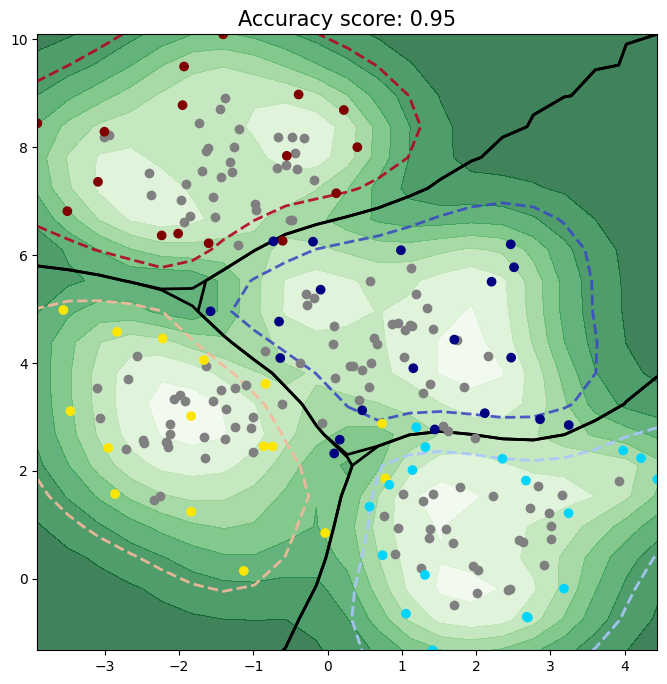

In [15]:
# Execute active learning cycle.
n_cycles = 40  # changed to 40 from 20
for c in range(n_cycles):
    query_idx = qs.query(X=X, y=y, clf=clf)
    y[query_idx] = y_true[query_idx]

# Fit final classifier.
clf.fit(X, y)

# Visualize resulting classifier and current utilities.
bound = [[min(X[:, 0]), min(X[:, 1])], [max(X[:, 0]), max(X[:, 1])]]
unlbld_idx = unlabeled_indices(y)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.set_title(f'Accuracy score: {clf.score(X,y_true)}', fontsize=15)
plot_utilities(qs, X=X, y=y, clf=clf, feature_bound=bound, ax=ax)
plot_decision_boundary(clf, feature_bound=bound, confidence=0.6)
plt.scatter(X[unlbld_idx,0], X[unlbld_idx,1], c='gray')
plt.scatter(X[:,0], X[:,1], c=y, cmap='jet')
plt.show()

### Stream Based Active Learning

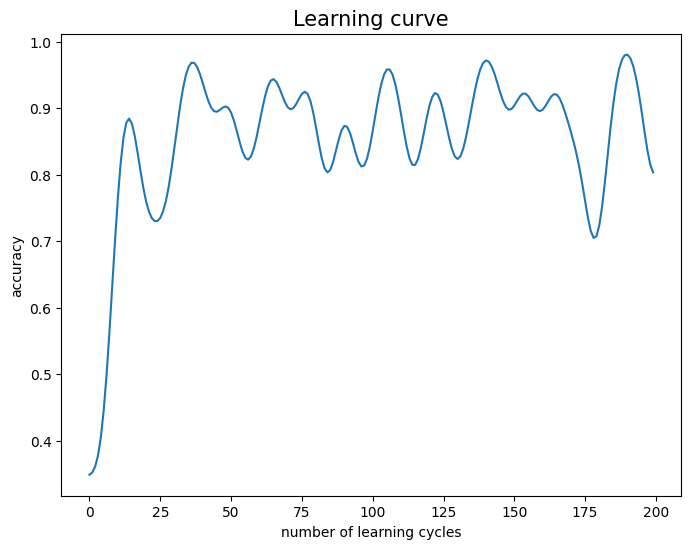

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from sklearn.datasets import make_blobs
from skactiveml.classifier import ParzenWindowClassifier
from skactiveml.stream import Split
from skactiveml.utils import MISSING_LABEL

# Generate data set.
X, y_true = make_blobs(n_samples=200, centers=4, random_state=0)

# Create classifier and query strategy.
clf = ParzenWindowClassifier(random_state=0, classes=np.unique(y_true))
qs = Split(random_state=0)

# Initializing the training data as an empty array.
X_train = []
y_train = []

# Initialize the list that stores the result of the classifier's prediction.
correct_classifications = []

# Execute active learning cycle.
for x_t, y_t in zip(X, y_true):
    X_cand = x_t.reshape([1, -1])
    y_cand = y_t
    clf.fit(X_train, y_train)
    correct_classifications.append(clf.predict(X_cand)[0] == y_cand)
    sampled_indices = qs.query(candidates=X_cand, clf=clf)
    qs.update(candidates=X_cand, queried_indices=sampled_indices)
    X_train.append(x_t)
    y_train.append(y_cand if len(sampled_indices) > 0 else MISSING_LABEL)

# Plot the classifier's learning accuracy.
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.set_title(f'Learning curve', fontsize=15)
ax.set_xlabel('number of learning cycles')
ax.set_ylabel('accuracy')
ax.plot(gaussian_filter1d(np.array(correct_classifications, dtype=float), 4))
plt.show()